# 🔍 Detecção de Fraude em Cartões de Crédito

## Projeto Completo de Machine Learning (Standalone)

Este notebook implementa um sistema de detecção de fraude utilizando:
- **Modelos Não Supervisionados**: Isolation Forest, K-Means
- **Modelos Supervisionados**: Random Forest, XGBoost
- **Comparação completa** dos 4 modelos

### Dataset
Credit Card Fraud Detection (Kaggle) - 284.807 transações com 492 fraudes (~0.17%)

---

## 1. Setup e Configuração

In [38]:
# Instalação de dependências (descomentar se necessário)
# !pip install pandas numpy scikit-learn xgboost matplotlib seaborn

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from pathlib import Path

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, precision_recall_curve, roc_curve,
    f1_score, precision_score, recall_score, accuracy_score, auc
)

# XGBoost
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

# Configurações
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

# Estilo de gráficos
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✓ Setup concluído!")
print(f"\nBibliotecas carregadas:")
print(f"  - pandas: {pd.__version__}")
print(f"  - numpy: {np.__version__}")
print(f"  - sklearn: OK")
print(f"  - xgboost: OK")

✓ Setup concluído!

Bibliotecas carregadas:
  - pandas: 2.3.2
  - numpy: 2.3.3
  - sklearn: OK
  - xgboost: OK


## 2. Funções Auxiliares

In [40]:
def print_section(title, char="=", width=60):
    """Imprime título de seção formatado."""
    print(f"\n{char * width}")
    print(f"{title.center(width)}")
    print(f"{char * width}\n")

def calculate_metrics(y_true, y_pred, y_proba=None):
    """Calcula métricas de classificação."""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    
    if y_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
        metrics['average_precision'] = average_precision_score(y_true, y_proba)
    
    return metrics

def print_evaluation_report(y_true, y_pred, y_proba=None, model_name="Model"):
    """Imprime relatório completo de avaliação."""
    print(f"\n{'='*60}")
    print(f"RELATÓRIO DE AVALIAÇÃO: {model_name}")
    print(f"{'='*60}")
    
    metrics = calculate_metrics(y_true, y_pred, y_proba)
    
    print(f"\nMÉTRICAS DE CLASSIFICAÇÃO:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1']:.4f}")
    
    if y_proba is not None:
        print(f"\nMÉTRICAS DE RANKING:")
        print(f"  ROC-AUC:            {metrics['roc_auc']:.4f}")
        print(f"  Average Precision:  {metrics['average_precision']:.4f}")
    
    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\nMATRIZ DE CONFUSÃO:")
    print(f"  True Negatives (TN):  {tn:,}")
    print(f"  False Positives (FP): {fp:,}")
    print(f"  False Negatives (FN): {fn:,}")
    print(f"  True Positives (TP):  {tp:,}")
    
    print(f"\nIMPACTO NO NEGÓCIO:")
    total_fraud = tp + fn
    print(f"  Fraudes no teste:     {total_fraud:,}")
    print(f"  Fraudes detectadas:   {tp:,} ({tp/total_fraud*100:.1f}%)")
    print(f"  Fraudes perdidas:     {fn:,} ({fn/total_fraud*100:.1f}%)")
    print(f"  Falsos alertas:       {fp:,}")
    
    print(f"{'='*60}\n")
    
    return metrics

print("✓ Funções auxiliares definidas!")

✓ Funções auxiliares definidas!


## 3. Carregamento dos Dados

In [41]:
# Caminho do dataset - ajuste conforme necessário
DATA_PATH = Path('D:/Downloads/archive (1)/creditcard.csv')

# Tentar caminhos alternativos
alternative_paths = [
    Path('creditcard.csv'),
    Path('data/creditcard.csv'),
    Path('../data/raw/creditcard.csv'),
    Path('../creditcard.csv'),
]

if not DATA_PATH.exists():
    for alt_path in alternative_paths:
        if alt_path.exists():
            DATA_PATH = alt_path
            break

if DATA_PATH.exists():
    print(f"✓ Dataset encontrado: {DATA_PATH}")
else:
    print(f"⚠️  Dataset não encontrado!")
    print("\nBaixe o dataset do Kaggle:")
    print("https://www.kaggle.com/mlg-ulb/creditcardfraud")
    print("\nColoque o arquivo creditcard.csv no mesmo diretório do notebook")

✓ Dataset encontrado: D:\Downloads\archive (1)\creditcard.csv


In [42]:
# Carregar dados
print("Carregando dados...")
start_time = time.time()

df = pd.read_csv(DATA_PATH)

print(f"✓ Dados carregados em {time.time() - start_time:.2f}s")
print(f"\nShape: {df.shape[0]:,} linhas x {df.shape[1]} colunas")

Carregando dados...
✓ Dados carregados em 1.92s

Shape: 284,807 linhas x 31 colunas


In [43]:
# Resumo do dataset
n_fraud = df['Class'].sum()
n_normal = len(df) - n_fraud

print_section("RESUMO DO DATASET")
print(f"Total de transações: {len(df):,}")
print(f"Número de features: {df.shape[1] - 1}")
print(f"\nDistribuição das classes:")
print(f"  - Transações normais: {n_normal:,} ({n_normal/len(df)*100:.2f}%)")
print(f"  - Transações fraudulentas: {n_fraud:,} ({n_fraud/len(df)*100:.4f}%)")
print(f"  - Razão de desbalanceamento: {n_normal/n_fraud:.0f}:1")
print(f"\nValores faltantes: {df.isnull().sum().sum()}")
print(f"Registros duplicados: {df.duplicated().sum()}")


                     RESUMO DO DATASET                      

Total de transações: 284,807
Número de features: 30

Distribuição das classes:
  - Transações normais: 284,315 (99.83%)
  - Transações fraudulentas: 492 (0.1727%)
  - Razão de desbalanceamento: 578:1

Valores faltantes: 0
Registros duplicados: 1081


In [44]:
# Visualizar primeiras linhas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0000,-1.3598,-0.0728,2.5363,1.3782,-0.3383,0.4624,0.2396,0.0987,0.3638,0.0908,-0.5516,-0.6178,-0.9914,-0.3112,1.4682,-0.4704,0.2080,0.0258,0.4040,0.2514,-0.0183,0.2778,-0.1105,0.0669,0.1285,-0.1891,0.1336,-0.0211,149.6200,0
1,0.0000,1.1919,0.2662,0.1665,0.4482,0.0600,-0.0824,-0.0788,0.0851,-0.2554,-0.1670,1.6127,1.0652,0.4891,-0.1438,0.6356,0.4639,-0.1148,-0.1834,-0.1458,-0.0691,-0.2258,-0.6387,0.1013,-0.3398,0.1672,0.1259,-0.0090,0.0147,2.6900,0
2,1.0000,-1.3584,-1.3402,1.7732,0.3798,-0.5032,1.8005,0.7915,0.2477,-1.5147,0.2076,0.6245,0.0661,0.7173,-0.1659,2.3459,-2.8901,1.1100,-0.1214,-2.2619,0.5250,0.2480,0.7717,0.9094,-0.6893,-0.3276,-0.1391,-0.0554,-0.0598,378.6600,0
3,1.0000,-0.9663,-0.1852,1.7930,-0.8633,-0.0103,1.2472,0.2376,0.3774,-1.3870,-0.0550,-0.2265,0.1782,0.5078,-0.2879,-0.6314,-1.0596,-0.6841,1.9658,-1.2326,-0.2080,-0.1083,0.0053,-0.1903,-1.1756,0.6474,-0.2219,0.0627,0.0615,123.5000,0
4,2.0000,-1.1582,0.8777,1.5487,0.4030,-0.4072,0.0959,0.5929,-0.2705,0.8177,0.7531,-0.8228,0.5382,1.3459,-1.1197,0.1751,-0.4514,-0.2370,-0.0382,0.8035,0.4085,-0.0094,0.7983,-0.1375,0.1413,-0.2060,0.5023,0.2194,0.2152,69.9900,0


In [45]:
# Estatísticas descritivas
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000
mean,94813.8596,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,88.3496,0.0017
std,47488.1460,1.9587,1.6513,1.5163,1.4159,1.3802,1.3323,1.2371,1.1944,1.0986,1.0888,1.0207,0.9992,0.9953,0.9586,0.9153,0.8763,0.8493,0.8382,0.8140,0.7709,0.7345,0.7257,0.6245,0.6056,0.5213,0.4822,0.4036,0.3301,250.1201,0.0415
min,0.0000,-56.4075,-72.7157,-48.3256,-5.6832,-113.7433,-26.1605,-43.5572,-73.2167,-13.4341,-24.5883,-4.7975,-18.6837,-5.7919,-19.2143,-4.4989,-14.1299,-25.1628,-9.4987,-7.2135,-54.4977,-34.8304,-10.9331,-44.8077,-2.8366,-10.2954,-2.6046,-22.5657,-15.4301,0.0000,0.0000
25%,54201.5000,-0.9204,-0.5985,-0.8904,-0.8486,-0.6916,-0.7683,-0.5541,-0.2086,-0.6431,-0.5354,-0.7625,-0.4056,-0.6485,-0.4256,-0.5829,-0.4680,-0.4837,-0.4988,-0.4563,-0.2117,-0.2284,-0.5424,-0.1618,-0.3546,-0.3171,-0.3270,-0.0708,-0.0530,5.6000,0.0000
50%,84692.0000,0.0181,0.0655,0.1798,-0.0198,-0.0543,-0.2742,0.0401,0.0224,-0.0514,-0.0929,-0.0328,0.1400,-0.0136,0.0506,0.0481,0.0664,-0.0657,-0.0036,0.0037,-0.0625,-0.0295,0.0068,-0.0112,0.0410,0.0166,-0.0521,0.0013,0.0112,22.0000,0.0000
75%,139320.5000,1.3156,0.8037,1.0272,0.7433,0.6119,0.3986,0.5704,0.3273,0.5971,0.4539,0.7396,0.6182,0.6625,0.4931,0.6488,0.5233,0.3997,0.5008,0.4589,0.1330,0.1864,0.5286,0.1476,0.4395,0.3507,0.2410,0.0910,0.0783,77.1650,0.0000
max,172792.0000,2.4549,22.0577,9.3826,16.8753,34.8017,73.3016,120.5895,20.0072,15.5950,23.7451,12.0189,7.8484,7.1269,10.5268,8.8777,17.3151,9.2535,5.0411,5.5920,39.4209,27.2028,10.5031,22.5284,4.5845,7.5196,3.5173,31.6122,33.8478,25691.1600,1.0000


## 4. Análise Exploratória dos Dados (EDA)

In [46]:
print_section("ANÁLISE EXPLORATÓRIA DOS DADOS")


               ANÁLISE EXPLORATÓRIA DOS DADOS               



### 4.1 Distribuição das Classes

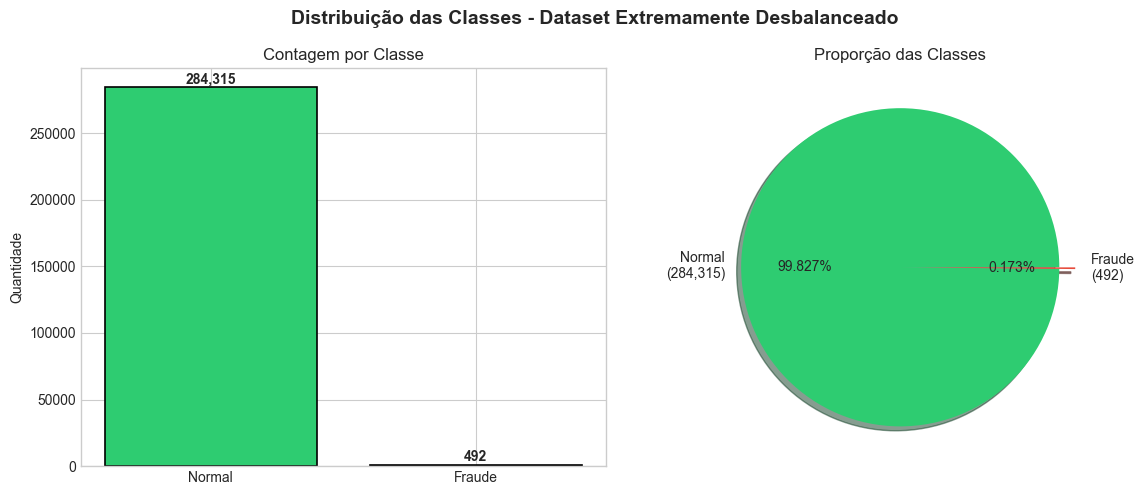


⚠️  ATENÇÃO: Dataset extremamente desbalanceado (0.17% fraudes)
   Isso requer técnicas especiais e métricas apropriadas!


In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras
counts = df['Class'].value_counts()
colors = ['#2ecc71', '#e74c3c']
labels = ['Normal', 'Fraude']

axes[0].bar(labels, counts.values, color=colors, edgecolor='black', linewidth=1.2)
axes[0].set_ylabel('Quantidade')
axes[0].set_title('Contagem por Classe')
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 3000, f'{v:,}', ha='center', fontweight='bold')

# Gráfico de pizza
axes[1].pie(
    counts.values,
    labels=[f'{l}\n({v:,})' for l, v in zip(labels, counts.values)],
    colors=colors,
    autopct='%1.3f%%',
    explode=(0, 0.1),
    shadow=True
)
axes[1].set_title('Proporção das Classes')

plt.suptitle('Distribuição das Classes - Dataset Extremamente Desbalanceado', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n⚠️  ATENÇÃO: Dataset extremamente desbalanceado (0.17% fraudes)")
print("   Isso requer técnicas especiais e métricas apropriadas!")

### 4.2 Análise da Variável Amount

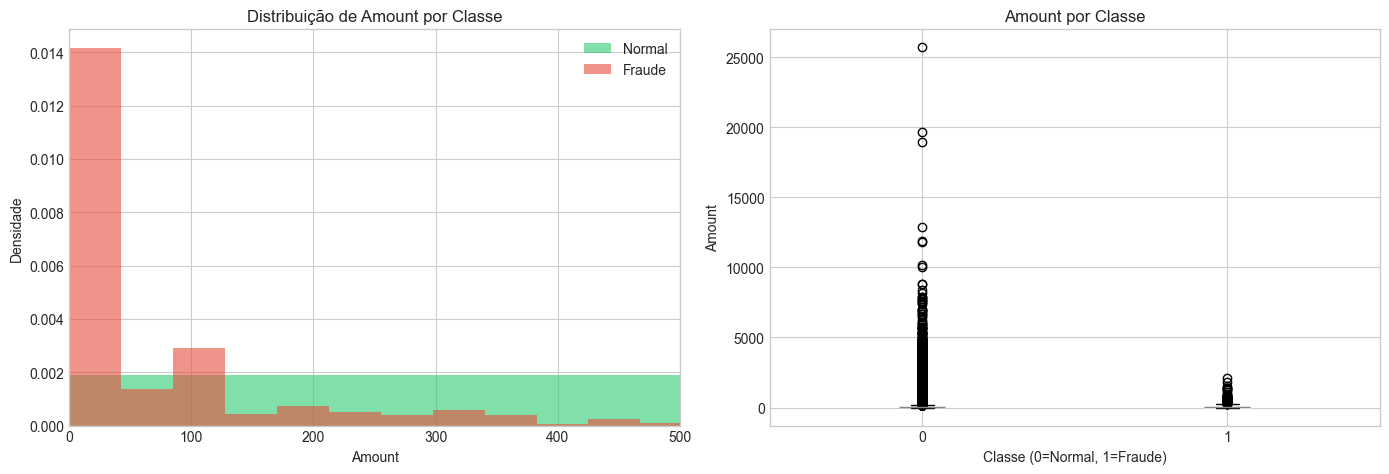


Estatísticas de Amount por Classe:
            count     mean      std    min    25%     50%      75%        max
Class                                                                        
0     284315.0000  88.2910 250.1051 0.0000 5.6500 22.0000  77.0500 25691.1600
1        492.0000 122.2113 256.6833 0.0000 1.0000  9.2500 105.8900  2125.8700


In [48]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribuição de Amount por classe
for label, color, name in [(0, '#2ecc71', 'Normal'), (1, '#e74c3c', 'Fraude')]:
    data = df[df['Class'] == label]['Amount']
    axes[0].hist(data, bins=50, alpha=0.6, color=color, label=name, density=True)

axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Densidade')
axes[0].set_title('Distribuição de Amount por Classe')
axes[0].legend()
axes[0].set_xlim(0, 500)

# Boxplot
df.boxplot(column='Amount', by='Class', ax=axes[1])
axes[1].set_title('Amount por Classe')
axes[1].set_xlabel('Classe (0=Normal, 1=Fraude)')
axes[1].set_ylabel('Amount')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("\nEstatísticas de Amount por Classe:")
print(df.groupby('Class')['Amount'].describe())

### 4.3 Análise Temporal

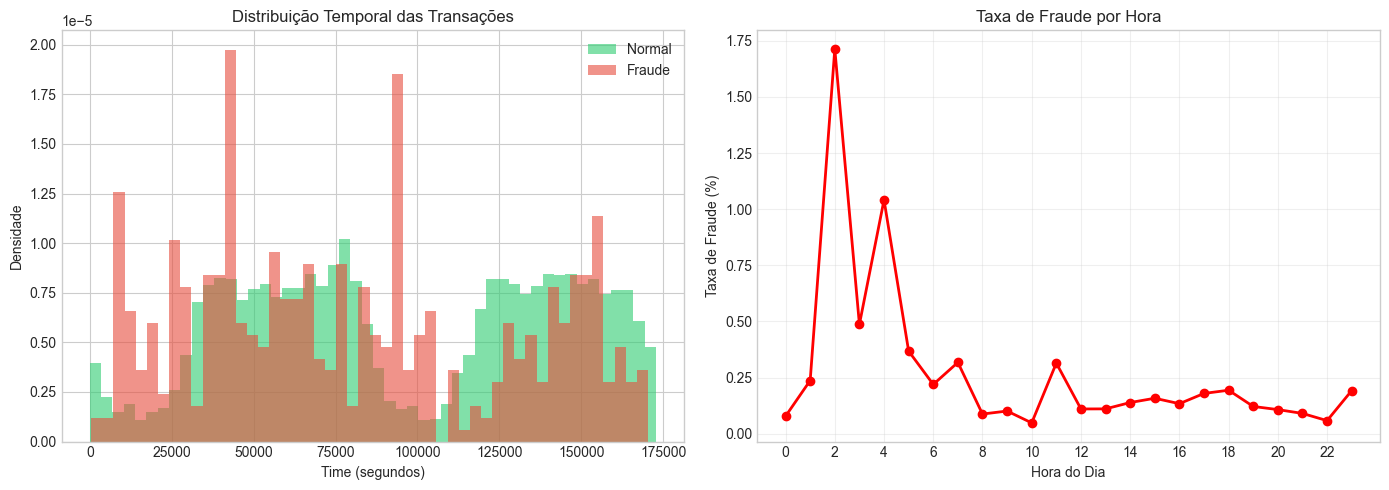

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribuição de Time por classe
for label, color, name in [(0, '#2ecc71', 'Normal'), (1, '#e74c3c', 'Fraude')]:
    data = df[df['Class'] == label]['Time']
    axes[0].hist(data, bins=50, alpha=0.6, color=color, label=name, density=True)

axes[0].set_xlabel('Time (segundos)')
axes[0].set_ylabel('Densidade')
axes[0].set_title('Distribuição Temporal das Transações')
axes[0].legend()

# Taxa de fraude por hora
df_temp = df.copy()
df_temp['Hour'] = (df_temp['Time'] / 3600) % 24
df_temp['Hour_bin'] = df_temp['Hour'].astype(int)

fraud_by_hour = df_temp.groupby('Hour_bin').agg(
    total=('Class', 'count'),
    fraud=('Class', 'sum')
)
fraud_by_hour['fraud_rate'] = fraud_by_hour['fraud'] / fraud_by_hour['total'] * 100

axes[1].plot(fraud_by_hour.index, fraud_by_hour['fraud_rate'], 'r-', linewidth=2, marker='o')
axes[1].set_xlabel('Hora do Dia')
axes[1].set_ylabel('Taxa de Fraude (%)')
axes[1].set_title('Taxa de Fraude por Hora')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

### 4.4 Análise das Features PCA (V1-V28)

In [50]:
# Calcular diferença entre classes para cada feature
pca_features = [f'V{i}' for i in range(1, 29)]

feature_stats = []
for col in pca_features:
    fraud_mean = df[df['Class'] == 1][col].mean()
    normal_mean = df[df['Class'] == 0][col].mean()
    normal_std = df[df['Class'] == 0][col].std()
    
    feature_stats.append({
        'feature': col,
        'mean_normal': normal_mean,
        'mean_fraud': fraud_mean,
        'mean_diff': abs(fraud_mean - normal_mean),
        'mean_diff_ratio': abs(fraud_mean - normal_mean) / (normal_std + 1e-8)
    })

feature_stats_df = pd.DataFrame(feature_stats).sort_values('mean_diff_ratio', ascending=False)

print("Top 10 Features com maior diferença entre classes:")
feature_stats_df.head(10)

Top 10 Features com maior diferença entre classes:


,feature,mean_normal,mean_fraud,mean_diff,mean_diff_ratio
16,V17,0.0115,-6.6658,6.6774,8.9096
13,V14,0.0121,-6.9717,6.9838,7.7857
11,V12,0.0108,-6.2594,6.2702,6.6286
9,V10,0.0098,-5.6769,5.6867,5.4460
15,V16,0.0072,-4.1399,4.1471,4.9091
2,V3,0.0122,-7.0333,7.0455,4.8275
6,V7,0.0096,-5.5687,5.5784,4.7322
10,V11,-0.0066,3.8002,3.8067,3.7949
3,V4,-0.0079,4.5420,4.5499,3.2515
17,V18,0.0039,-2.2463,2.2502,2.7278


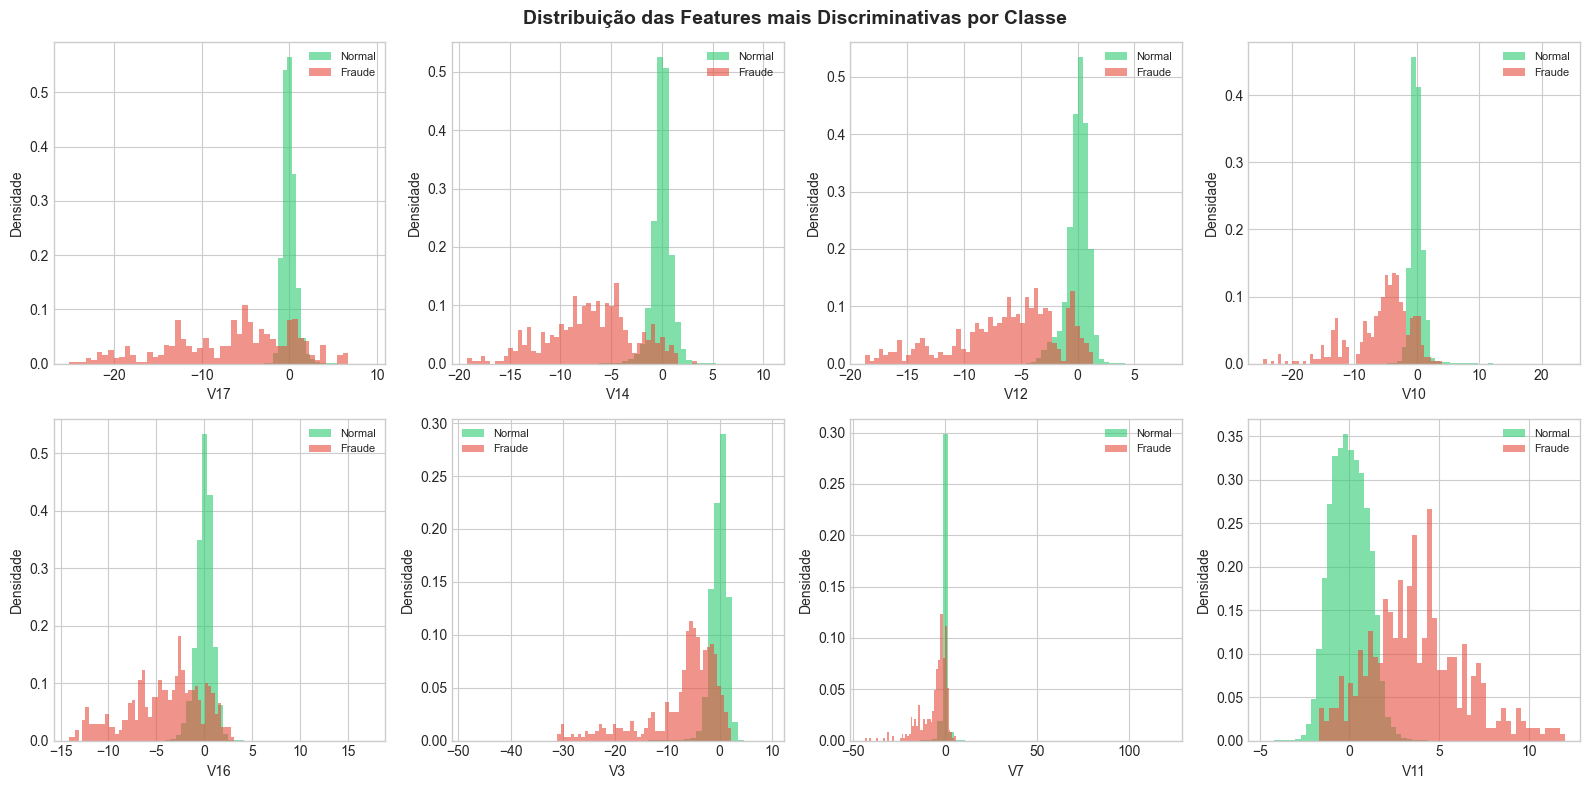

In [51]:
# Plotar as 8 features mais discriminativas
top_features = feature_stats_df.head(8)['feature'].tolist()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    
    for label, color in [(0, '#2ecc71'), (1, '#e74c3c')]:
        data = df[df['Class'] == label][feature]
        ax.hist(data, bins=50, alpha=0.6, color=color, 
               label='Normal' if label == 0 else 'Fraude', density=True)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Densidade')
    ax.legend(fontsize=8)

plt.suptitle('Distribuição das Features mais Discriminativas por Classe', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.5 Insights da EDA

**Principais descobertas:**
1. **Desbalanceamento extremo**: Apenas 0.17% das transações são fraudulentas
2. **Valor das transações**: Fraudes têm valor médio menor que transações normais
3. **Features discriminativas**: V14, V12, V10, V17 mostram clara separação entre classes
4. **Padrões temporais**: Fraudes parecem ter distribuição similar ao longo do tempo

## 5. Engenharia de Features

In [52]:
print_section("ENGENHARIA DE FEATURES")


                   ENGENHARIA DE FEATURES                   



In [53]:
# Criar cópia para processamento
df_processed = df.copy()

# Feature 1: Hora do dia (cíclica)
df_processed['Hour'] = (df_processed['Time'] / 3600) % 24
df_processed['Hour_sin'] = np.sin(2 * np.pi * df_processed['Hour'] / 24)
df_processed['Hour_cos'] = np.cos(2 * np.pi * df_processed['Hour'] / 24)
print("✓ Features temporais criadas: Hour_sin, Hour_cos")

# Feature 2: Log do Amount
df_processed['Amount_log'] = np.log1p(df_processed['Amount'])
print("✓ Feature de valor criada: Amount_log")

# Feature 3: Magnitude das principais componentes PCA
top_pca = ['V14', 'V12', 'V10', 'V17', 'V16', 'V3', 'V7', 'V11']
df_processed['PCA_magnitude'] = np.sqrt((df_processed[top_pca] ** 2).sum(axis=1))
print("✓ Feature de magnitude PCA criada")

# Feature 4: Interação V14 * V12 (as duas mais discriminativas)
df_processed['V14_V12'] = df_processed['V14'] * df_processed['V12']
print("✓ Feature de interação criada: V14_V12")

print(f"\nTotal de features: {df_processed.shape[1] - 1}")

✓ Features temporais criadas: Hour_sin, Hour_cos
✓ Feature de valor criada: Amount_log
✓ Feature de magnitude PCA criada
✓ Feature de interação criada: V14_V12

Total de features: 36


In [54]:
# Separar features e target
cols_to_drop = ['Class', 'Time', 'Hour']  # Time e Hour já foram transformados
X = df_processed.drop(columns=cols_to_drop)
y = df_processed['Class']

print(f"Shape X: {X.shape}")
print(f"Shape y: {y.shape}")
print(f"\nFeatures ({len(X.columns)}): {list(X.columns)}")

Shape X: (284807, 34)
Shape y: (284807,)

Features (34): ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Hour_sin', 'Hour_cos', 'Amount_log', 'PCA_magnitude', 'V14_V12']


In [55]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Conjunto de treino: {X_train.shape[0]:,} amostras")
print(f"Conjunto de teste: {X_test.shape[0]:,} amostras")
print(f"\nDistribuição no treino:")
print(f"  - Normal: {(y_train == 0).sum():,}")
print(f"  - Fraude: {(y_train == 1).sum():,}")
print(f"\nDistribuição no teste:")
print(f"  - Normal: {(y_test == 0).sum():,}")
print(f"  - Fraude: {(y_test == 1).sum():,}")

Conjunto de treino: 227,845 amostras
Conjunto de teste: 56,962 amostras

Distribuição no treino:
  - Normal: 227,451
  - Fraude: 394

Distribuição no teste:
  - Normal: 56,864
  - Fraude: 98


In [56]:
# Escalar features
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("✓ Features escaladas com RobustScaler")

✓ Features escaladas com RobustScaler


## 6. Modelos de Detecção de Anomalias (Não Supervisionados)

Vamos começar com abordagens não supervisionadas que detectam anomalias baseadas na distribuição dos dados.

In [57]:
print_section("MODELOS NÃO SUPERVISIONADOS")


                MODELOS NÃO SUPERVISIONADOS                 



### 6.1 Isolation Forest

**Justificativa**: O Isolation Forest isola anomalias através de particionamento aleatório. Pontos anômalos (como fraudes) são isolados mais rapidamente pois têm valores extremos ou combinações incomuns de features. É ideal para detectar **outliers multidimensionais** sem precisar de labels.

In [58]:
print("Treinando Isolation Forest...")
print("  - Treina apenas com dados normais para aprender o 'comportamento normal'")
print("  - Detecta pontos que diferem significativamente desse padrão\n")

# Treinar apenas com transações normais
X_train_normal = X_train_scaled[y_train == 0]
print(f"Treinando com {len(X_train_normal):,} transações normais")

start_time = time.time()

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.002,  # ~0.2% esperado de anomalias
    random_state=RANDOM_STATE,
    n_jobs=-1
)

iso_forest.fit(X_train_normal)

print(f"✓ Isolation Forest treinado em {time.time() - start_time:.2f}s")

Treinando Isolation Forest...
  - Treina apenas com dados normais para aprender o 'comportamento normal'
  - Detecta pontos que diferem significativamente desse padrão

Treinando com 227,451 transações normais
✓ Isolation Forest treinado em 1.39s


In [59]:
# Predição
# Isolation Forest retorna: 1 para normal, -1 para anomalia
iso_pred_raw = iso_forest.predict(X_test_scaled)
iso_pred = (iso_pred_raw == 1).astype(int)  # Converter: -1 (anomalia) -> 1 (fraude)

# Score de anomalia (quanto menor, mais anômalo)
iso_scores = iso_forest.score_samples(X_test_scaled)
# Inverter para ter probabilidade de anomalia (maior = mais provável fraude)
iso_proba = 1 - (iso_scores - iso_scores.min()) / (iso_scores.max() - iso_scores.min())

# Avaliar
iso_metrics = print_evaluation_report(y_test.values, iso_pred, iso_proba, "Isolation Forest")


RELATÓRIO DE AVALIAÇÃO: Isolation Forest

MÉTRICAS DE CLASSIFICAÇÃO:
  Accuracy:  0.0030
  Precision: 0.0012
  Recall:    0.6837
  F1-Score:  0.0024

MÉTRICAS DE RANKING:
  ROC-AUC:            0.9561
  Average Precision:  0.1658

MATRIZ DE CONFUSÃO:
  True Negatives (TN):  104
  False Positives (FP): 56,760
  False Negatives (FN): 31
  True Positives (TP):  67

IMPACTO NO NEGÓCIO:
  Fraudes no teste:     98
  Fraudes detectadas:   67 (68.4%)
  Fraudes perdidas:     31 (31.6%)
  Falsos alertas:       56,760



### 6.2 K-Means Clustering

**Justificativa**: K-Means agrupa dados em clusters. Transações que ficam **muito distantes dos centroides** são consideradas anômalas. A ideia é que fraudes formam um padrão diferente das transações normais e, portanto, ficam em regiões de baixa densidade ou longe dos centros dos clusters.

In [60]:
print("Treinando K-Means...")
print("  - Agrupa transações em clusters")
print("  - Pontos distantes dos centroides são suspeitos\n")

start_time = time.time()

# Usar 8 clusters (ajustável)
kmeans = KMeans(
    n_clusters=8,
    random_state=RANDOM_STATE,
    n_init=10
)

# Treinar com todos os dados de treino
kmeans.fit(X_train_scaled)

print(f"✓ K-Means treinado em {time.time() - start_time:.2f}s")

Treinando K-Means...
  - Agrupa transações em clusters
  - Pontos distantes dos centroides são suspeitos

✓ K-Means treinado em 3.31s


In [61]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# ======================================================
# Distâncias ao centróide mais próximo (K-Means)
# ======================================================

train_distances = kmeans.transform(X_train_scaled).min(axis=1)
test_distances = kmeans.transform(X_test_scaled).min(axis=1)

# Score contínuo normalizado
dist_min = test_distances.min()
dist_max = test_distances.max()
kmeans_proba = (test_distances - dist_min) / (dist_max - dist_min)

# ======================================================
# Avaliação por percentil (80 a 99)
# ======================================================

results = []

for percentile in range(80, 100):
    threshold = np.percentile(train_distances, percentile)

    y_pred = (test_distances > threshold).astype(int)

    # Matriz de confusão
    tn, fp, fn, tp = confusion_matrix(y_test.values, y_pred).ravel()

    # Métricas auxiliares (opcional)
    metrics = calculate_metrics(
        y_true=y_test.values,
        y_pred=y_pred,
        y_proba=kmeans_proba
    )

    results.append({
        "percentile": percentile,
        "threshold": threshold,
        "fraudes_detectadas": tp,
        "fraudes_perdidas": fn,
        "falsos_alertas": fp,
        "recall": metrics.get("recall", tp / (tp + fn))
    })

results_df = pd.DataFrame(results)

# ======================================================
# Critério de negócio:
# 1. Maximizar fraudes detectadas
# 2. Minimizar falsos alertas
# ======================================================

results_df = results_df.sort_values(
    by=["fraudes_detectadas", "falsos_alertas"],
    ascending=[False, True]
)

best_result = results_df.iloc[0]

best_percentile = best_result["percentile"]
best_threshold = best_result["threshold"]

# ======================================================
# Avaliação final com o melhor percentil
# ======================================================

final_predictions = (test_distances > best_threshold).astype(int)

print_evaluation_report(
    y_test.values,
    final_predictions,
    kmeans_proba,
    f"K-Means (Distance-based) - Percentil {best_percentile}"
)



RELATÓRIO DE AVALIAÇÃO: K-Means (Distance-based) - Percentil 80.0

MÉTRICAS DE CLASSIFICAÇÃO:
  Accuracy:  0.7992
  Precision: 0.0081
  Recall:    0.9490
  F1-Score:  0.0160

MÉTRICAS DE RANKING:
  ROC-AUC:            0.9547
  Average Precision:  0.1872

MATRIZ DE CONFUSÃO:
  True Negatives (TN):  45,431
  False Positives (FP): 11,433
  False Negatives (FN): 5
  True Positives (TP):  93

IMPACTO NO NEGÓCIO:
  Fraudes no teste:     98
  Fraudes detectadas:   93 (94.9%)
  Fraudes perdidas:     5 (5.1%)
  Falsos alertas:       11,433



{'accuracy': 0.7991994663108739,
 'precision': 0.008068714211348256,
 'recall': 0.9489795918367347,
 'f1': 0.016001376462491397,
 'roc_auc': 0.9547046730903954,
 'average_precision': 0.18722079628030094}

## 7. Modelos Supervisionados

Agora vamos treinar modelos que usam os labels para aprender padrões de fraude.

In [62]:
print_section("MODELOS SUPERVISIONADOS")


                  MODELOS SUPERVISIONADOS                   



### 7.1 Random Forest

**Justificativa**: Random Forest é um ensemble de árvores de decisão que:
- Captura **interações não-lineares** entre features
- É **robusto a overfitting** devido ao bagging
- Suporta **class_weight='balanced'** para lidar com desbalanceamento
- Fornece **importância das features** para interpretabilidade

In [63]:
print("Treinando Random Forest...")
print("  - Ensemble de árvores de decisão")
print("  - class_weight='balanced' para compensar desbalanceamento\n")

start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

print(f"✓ Random Forest treinado em {time.time() - start_time:.2f}s")

Treinando Random Forest...
  - Ensemble de árvores de decisão
  - class_weight='balanced' para compensar desbalanceamento

✓ Random Forest treinado em 16.52s


In [ ]:
# Predição
rf_pred = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Avaliar
rf_metrics = print_evaluation_report(y_test.values, rf_pred, rf_proba, "Random Forest")


RELATÓRIO DE AVALIAÇÃO: Random Forest

MÉTRICAS DE CLASSIFICAÇÃO:
  Accuracy:  0.9992
  Precision: 0.7619
  Recall:    0.8163
  F1-Score:  0.7882

MÉTRICAS DE RANKING:
  ROC-AUC:            0.9787
  Average Precision:  0.8157

MATRIZ DE CONFUSÃO:
  True Negatives (TN):  56,839
  False Positives (FP): 25
  False Negatives (FN): 18
  True Positives (TP):  80

IMPACTO NO NEGÓCIO:
  Fraudes no teste:     98
  Fraudes detectadas:   80 (81.6%)
  Fraudes perdidas:     18 (18.4%)
  Falsos alertas:       25



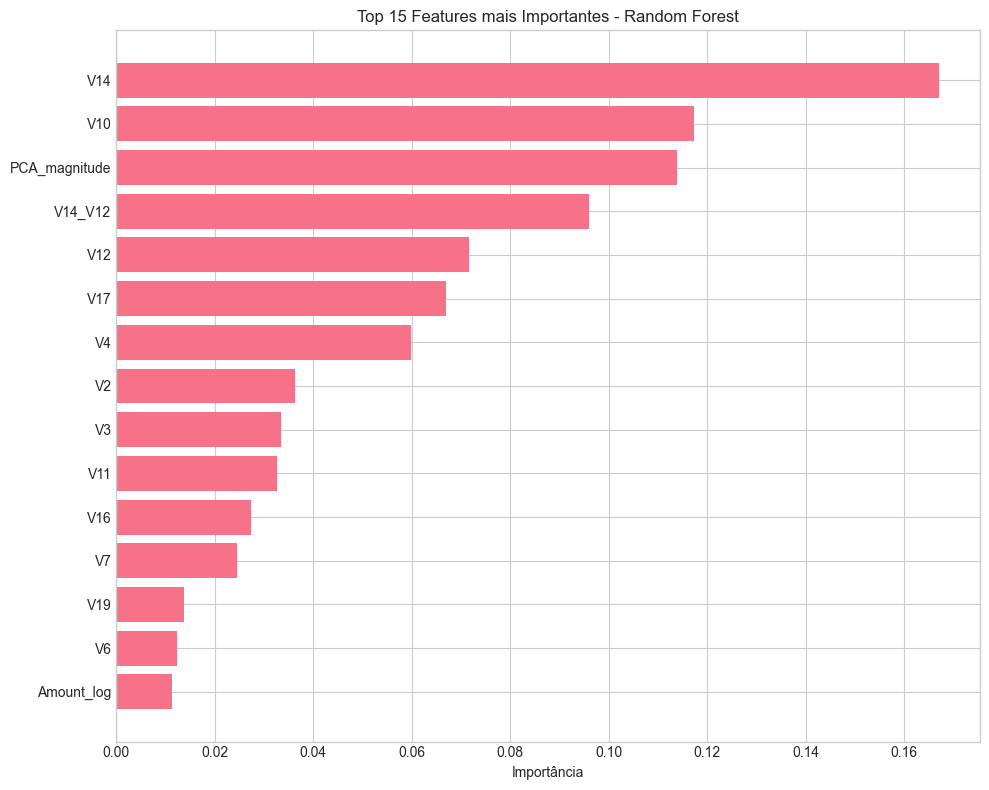

In [65]:
# Importância das features
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_n = 15
plt.barh(range(top_n), rf_importance.head(top_n)['importance'].values[::-1])
plt.yticks(range(top_n), rf_importance.head(top_n)['feature'].values[::-1])
plt.xlabel('Importância')
plt.title('Top 15 Features mais Importantes - Random Forest')
plt.tight_layout()
plt.show()

In [69]:
import time
import optuna
import numpy as np
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score

# ======================================================
# LOCALIZAÇÃO DO DATASET E DO ESTUDO
# ======================================================

DATA_PATH = Path(r"D:/Downloads/archive (1)/creditcard.csv")

if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset não encontrado: {DATA_PATH}")

# O estudo será salvo NO MESMO DIRETÓRIO do CSV
STUDY_DB_PATH = DATA_PATH.parent / "optuna_rf_fraude.db"
STUDY_NAME = "rf_fraude_study"

# ======================================================
# FUNÇÃO OBJETIVO DO OPTUNA
# ======================================================

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200, step=50),
        "max_depth": trial.suggest_int("max_depth", 5, 15, step=5),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1,5),
        "max_features": trial.suggest_categorical(
            "max_features", ["sqrt", "log2", 0.3, 0.5]
        ),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "class_weight": "balanced",
        "random_state": RANDOM_STATE,
        "n_jobs": -1
    }

    model = RandomForestClassifier(**params)

    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=RANDOM_STATE
    )

    recalls = []

    for train_idx, val_idx in cv.split(X_train_scaled, y_train):
        X_tr = X_train_scaled.iloc[train_idx]
        X_val = X_train_scaled.iloc[val_idx]

        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        recalls.append(recall_score(y_val, y_pred))

    return float(np.mean(recalls))

# ======================================================
# CRIAR OU CARREGAR O ESTUDO (PERSISTENTE)
# ======================================================

study = optuna.create_study(
    study_name=STUDY_NAME,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    storage=f"sqlite:///{STUDY_DB_PATH}",
    load_if_exists=True
)

# ======================================================
# EXECUÇÃO / CONTINUAÇÃO DA OTIMIZAÇÃO
# ======================================================

start_time = time.time()

study.optimize(
    objective,
    n_trials=40,              # adiciona 40 novos trials
    show_progress_bar=True
)

elapsed_time = time.time() - start_time

# ======================================================
# MELHORES RESULTADOS
# ======================================================

best_params = study.best_params
best_score = study.best_value

print(f"Tempo da execução: {elapsed_time:.2f} segundos")
print(f"Melhor recall médio (CV): {best_score:.4f}")
print("Melhores hiperparâmetros:")

for k, v in best_params.items():
    print(f"{k}: {v}")

# ======================================================
# TREINO FINAL COM TODOS OS DADOS DE TREINO
# ======================================================

best_rf = RandomForestClassifier(
    **best_params,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

best_rf.fit(X_train_scaled, y_train)

# ======================================================
# AVALIAÇÃO NO CONJUNTO DE TESTE
# ======================================================

y_pred = best_rf.predict(X_test_scaled)
y_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

print_evaluation_report(
    y_test.values,
    y_pred,
    y_proba,
    "Random Forest (Optuna Persistente)"
)


[I 2025-12-14 22:40:29,823] Using an existing study with name 'rf_fraude_study' instead of creating a new one.
Best trial: 1. Best value: 0.794433:   2%|▎         | 1/40 [03:18<2:09:01, 198.49s/it]

[I 2025-12-14 22:43:48,313] Trial 1 finished with value: 0.7944328784023441 and parameters: {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.5, 'bootstrap': False}. Best is trial 1 with value: 0.7944328784023441.


Best trial: 1. Best value: 0.794433:   5%|▌         | 2/40 [05:10<1:33:37, 147.83s/it]

[I 2025-12-14 22:45:40,684] Trial 2 finished with value: 0.784235484617164 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': True}. Best is trial 1 with value: 0.7944328784023441.


Best trial: 3. Best value: 0.840138:   8%|▊         | 3/40 [05:49<1:00:23, 97.94s/it] 

[I 2025-12-14 22:46:19,249] Trial 3 finished with value: 0.8401380214357314 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 3 with value: 0.8401380214357314.


Best trial: 4. Best value: 0.842683:  10%|█         | 4/40 [06:27<44:34, 74.30s/it]  

[I 2025-12-14 22:46:57,308] Trial 4 finished with value: 0.842682550697818 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 4 with value: 0.842682550697818.


Best trial: 4. Best value: 0.842683:  12%|█▎        | 5/40 [07:09<36:35, 62.74s/it]

[I 2025-12-14 22:47:39,542] Trial 5 finished with value: 0.79441360166551 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 4 with value: 0.842682550697818.


Best trial: 4. Best value: 0.842683:  15%|█▌        | 6/40 [09:41<52:37, 92.85s/it]

[I 2025-12-14 22:50:10,865] Trial 6 finished with value: 0.7994833834528491 and parameters: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 4 with value: 0.842682550697818.


Best trial: 7. Best value: 0.847733:  18%|█▊        | 7/40 [13:16<1:13:03, 132.84s/it]

[I 2025-12-14 22:53:46,018] Trial 7 finished with value: 0.8477330557483228 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 7 with value: 0.8477330557483228.


Best trial: 7. Best value: 0.847733:  20%|██        | 8/40 [15:12<1:08:05, 127.68s/it]

[I 2025-12-14 22:55:42,644] Trial 8 finished with value: 0.842682550697818 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 0.3, 'bootstrap': True}. Best is trial 7 with value: 0.8477330557483228.


Best trial: 7. Best value: 0.847733:  22%|██▎       | 9/40 [18:04<1:13:00, 141.32s/it]

[I 2025-12-14 22:58:33,957] Trial 9 finished with value: 0.7918690724034235 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 0.3, 'bootstrap': True}. Best is trial 7 with value: 0.8477330557483228.


Best trial: 7. Best value: 0.847733:  25%|██▌       | 10/40 [19:24<1:01:12, 122.42s/it]

[I 2025-12-14 22:59:54,050] Trial 10 finished with value: 0.7969581309275965 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 7 with value: 0.8477330557483228.


Best trial: 7. Best value: 0.847733:  28%|██▊       | 11/40 [23:01<1:13:14, 151.54s/it]

[I 2025-12-14 23:03:31,621] Trial 11 finished with value: 0.8477330557483228 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 7 with value: 0.8477330557483228.


Best trial: 7. Best value: 0.847733:  30%|███       | 12/40 [26:33<1:19:17, 169.92s/it]

[I 2025-12-14 23:07:03,580] Trial 12 finished with value: 0.8477330557483228 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 7 with value: 0.8477330557483228.


Best trial: 7. Best value: 0.847733:  32%|███▎      | 13/40 [32:15<1:39:55, 222.05s/it]

[I 2025-12-14 23:12:45,596] Trial 13 finished with value: 0.804553165240188 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 7 with value: 0.8477330557483228.


Best trial: 7. Best value: 0.847733:  35%|███▌      | 14/40 [35:45<1:34:35, 218.29s/it]

[I 2025-12-14 23:16:15,176] Trial 14 finished with value: 0.8477330557483228 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 7 with value: 0.8477330557483228.


Best trial: 15. Best value: 0.850258:  38%|███▊      | 15/40 [38:55<1:27:26, 209.88s/it]

[I 2025-12-14 23:19:25,551] Trial 15 finished with value: 0.8502583082735754 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 15 with value: 0.8502583082735754.


Best trial: 15. Best value: 0.850258:  40%|████      | 16/40 [44:26<1:38:30, 246.27s/it]

[I 2025-12-14 23:24:56,335] Trial 16 finished with value: 0.8070976945022746 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 0.5, 'bootstrap': False}. Best is trial 15 with value: 0.8502583082735754.


Best trial: 15. Best value: 0.850258:  42%|████▎     | 17/40 [47:09<1:24:46, 221.14s/it]

[I 2025-12-14 23:27:39,034] Trial 17 finished with value: 0.8070976945022746 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.5, 'bootstrap': False}. Best is trial 15 with value: 0.8502583082735754.


Best trial: 18. Best value: 0.860456:  45%|████▌     | 18/40 [48:37<1:06:23, 181.09s/it]

[I 2025-12-14 23:29:06,890] Trial 18 finished with value: 0.8604557020587555 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  48%|████▊     | 19/40 [49:37<50:41, 144.85s/it]  

[I 2025-12-14 23:30:07,325] Trial 19 finished with value: 0.8604557020587555 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  50%|█████     | 20/40 [51:16<43:40, 131.00s/it]

[I 2025-12-14 23:31:46,059] Trial 20 finished with value: 0.8070976945022745 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  52%|█████▎    | 21/40 [52:14<34:36, 109.30s/it]

[I 2025-12-14 23:32:44,768] Trial 21 finished with value: 0.8604557020587555 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  55%|█████▌    | 22/40 [53:16<28:29, 94.97s/it] 

[I 2025-12-14 23:33:46,315] Trial 22 finished with value: 0.8604557020587555 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  57%|█████▊    | 23/40 [54:20<24:14, 85.55s/it]

[I 2025-12-14 23:34:49,901] Trial 23 finished with value: 0.8604557020587555 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  60%|██████    | 24/40 [55:25<21:12, 79.52s/it]

[I 2025-12-14 23:35:55,346] Trial 24 finished with value: 0.8579111727966691 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  62%|██████▎   | 25/40 [56:29<18:43, 74.88s/it]

[I 2025-12-14 23:36:59,397] Trial 25 finished with value: 0.8604557020587555 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  65%|██████▌   | 26/40 [57:33<16:41, 71.54s/it]

[I 2025-12-14 23:38:03,158] Trial 26 finished with value: 0.8579111727966691 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  68%|██████▊   | 27/40 [59:18<17:39, 81.53s/it]

[I 2025-12-14 23:39:47,991] Trial 27 finished with value: 0.8070976945022745 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  70%|███████   | 28/40 [1:00:22<15:15, 76.27s/it]

[I 2025-12-14 23:40:51,975] Trial 28 finished with value: 0.8579111727966691 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  72%|███████▎  | 29/40 [1:01:41<14:10, 77.29s/it]

[I 2025-12-14 23:42:11,637] Trial 29 finished with value: 0.8071169712391085 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  75%|███████▌  | 30/40 [1:03:45<15:11, 91.18s/it]

[I 2025-12-14 23:44:15,244] Trial 30 finished with value: 0.8604557020587555 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  78%|███████▊  | 31/40 [1:05:18<13:45, 91.70s/it]

[I 2025-12-14 23:45:48,144] Trial 31 finished with value: 0.8604557020587555 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  80%|████████  | 32/40 [1:06:22<11:06, 83.32s/it]

[I 2025-12-14 23:46:51,931] Trial 32 finished with value: 0.8604557020587555 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  82%|████████▎ | 33/40 [1:07:26<09:02, 77.52s/it]

[I 2025-12-14 23:47:55,900] Trial 33 finished with value: 0.8604557020587555 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  85%|████████▌ | 34/40 [1:08:28<07:17, 72.91s/it]

[I 2025-12-14 23:48:58,054] Trial 34 finished with value: 0.8604557020587555 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  88%|████████▊ | 35/40 [1:09:11<05:19, 63.93s/it]

[I 2025-12-14 23:49:41,035] Trial 35 finished with value: 0.842682550697818 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 0.3, 'bootstrap': True}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  90%|█████████ | 36/40 [1:09:34<03:26, 51.71s/it]

[I 2025-12-14 23:50:04,240] Trial 36 finished with value: 0.8401380214357314 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  92%|█████████▎| 37/40 [1:10:31<02:39, 53.17s/it]

[I 2025-12-14 23:51:00,824] Trial 37 finished with value: 0.7969388541907626 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  95%|█████████▌| 38/40 [1:11:04<01:34, 47.21s/it]

[I 2025-12-14 23:51:34,110] Trial 38 finished with value: 0.8604557020587555 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456:  98%|█████████▊| 39/40 [1:11:47<00:46, 46.03s/it]

[I 2025-12-14 23:52:17,378] Trial 39 finished with value: 0.842682550697818 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 0.3, 'bootstrap': True}. Best is trial 18 with value: 0.8604557020587555.


Best trial: 18. Best value: 0.860456: 100%|██████████| 40/40 [1:14:18<00:00, 111.47s/it]


[I 2025-12-14 23:54:48,625] Trial 40 finished with value: 0.8096229470275271 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': False}. Best is trial 18 with value: 0.8604557020587555.
Tempo da execução: 4458.81 segundos
Melhor recall médio (CV): 0.8605
Melhores hiperparâmetros:
n_estimators: 150
max_depth: 5
min_samples_split: 5
min_samples_leaf: 3
max_features: 0.3
bootstrap: False

RELATÓRIO DE AVALIAÇÃO: Random Forest (Optuna Persistente)

MÉTRICAS DE CLASSIFICAÇÃO:
  Accuracy:  0.9962
  Precision: 0.2959
  Recall:    0.8878
  F1-Score:  0.4439

MÉTRICAS DE RANKING:
  ROC-AUC:            0.9769
  Average Precision:  0.6793

MATRIZ DE CONFUSÃO:
  True Negatives (TN):  56,657
  False Positives (FP): 207
  False Negatives (FN): 11
  True Positives (TP):  87

IMPACTO NO NEGÓCIO:
  Fraudes no teste:     98
  Fraudes detectadas:   87 (88.8%)
  Fraudes perdidas:     11 (11.2%)
  Falsos alertas:       207


{'accuracy': 0.9961728871879498,
 'precision': 0.29591836734693877,
 'recall': 0.8877551020408163,
 'f1': 0.44387755102040816,
 'roc_auc': 0.9768502434738666,
 'average_precision': 0.6792785981526861}

### 7.2 XGBoost

**Justificativa**: XGBoost é um algoritmo de gradient boosting otimizado que:
- Geralmente obtém **melhor performance** em dados tabulares
- Suporta **scale_pos_weight** para compensar classes desbalanceadas
- Tem **regularização** embutida para evitar overfitting
- É **mais rápido** que implementações tradicionais de boosting

In [72]:
print("Treinando XGBoost...")
print("  - Gradient boosting otimizado")
print("  - scale_pos_weight para compensar desbalanceamento\n")

# Calcular peso para classe positiva
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

start_time = time.time()

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='aucpr',
    use_label_encoder=False
)

xgb_model.fit(X_train_scaled, y_train)

print(f"\n✓ XGBoost treinado em {time.time() - start_time:.2f}s")

Treinando XGBoost...
  - Gradient boosting otimizado
  - scale_pos_weight para compensar desbalanceamento

scale_pos_weight: 577.29

✓ XGBoost treinado em 8.09s


In [73]:
# Predição
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Avaliar
xgb_metrics = print_evaluation_report(y_test.values, xgb_pred, xgb_proba, "XGBoost")


RELATÓRIO DE AVALIAÇÃO: XGBoost

MÉTRICAS DE CLASSIFICAÇÃO:
  Accuracy:  0.9995
  Precision: 0.8830
  Recall:    0.8469
  F1-Score:  0.8646

MÉTRICAS DE RANKING:
  ROC-AUC:            0.9696
  Average Precision:  0.8730

MATRIZ DE CONFUSÃO:
  True Negatives (TN):  56,853
  False Positives (FP): 11
  False Negatives (FN): 15
  True Positives (TP):  83

IMPACTO NO NEGÓCIO:
  Fraudes no teste:     98
  Fraudes detectadas:   83 (84.7%)
  Fraudes perdidas:     15 (15.3%)
  Falsos alertas:       11



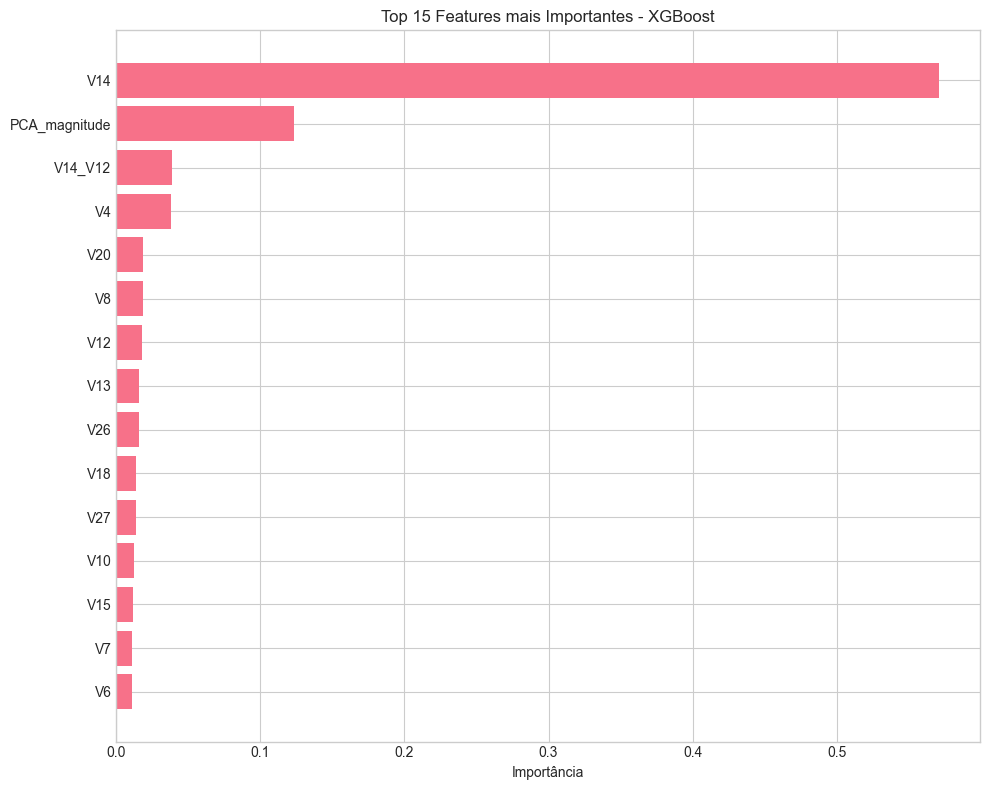

In [74]:
# Importância das features - XGBoost
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_n = 15
plt.barh(range(top_n), xgb_importance.head(top_n)['importance'].values[::-1])
plt.yticks(range(top_n), xgb_importance.head(top_n)['feature'].values[::-1])
plt.xlabel('Importância')
plt.title('Top 15 Features mais Importantes - XGBoost')
plt.tight_layout()
plt.show()

## 8. Comparação Final dos Modelos

In [75]:
print_section("COMPARAÇÃO FINAL DOS MODELOS")


                COMPARAÇÃO FINAL DOS MODELOS                



In [76]:
# Consolidar resultados
all_results = {
    'Isolation Forest': iso_metrics,
    'K-Means': kmeans_metrics,
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics
}

all_predictions = {
    'Isolation Forest': iso_pred,
    'K-Means': kmeans_pred,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
}

all_probabilities = {
    'Isolation Forest': iso_proba,
    'K-Means': kmeans_proba,
    'Random Forest': rf_proba,
    'XGBoost': xgb_proba
}

# Criar DataFrame de comparação
comparison_data = []
for model_name, metrics in all_results.items():
    comparison_data.append({
        'Modelo': model_name,
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'ROC-AUC': metrics.get('roc_auc', 0),
        'Avg Precision': metrics.get('average_precision', 0)
    })

comparison_df = pd.DataFrame(comparison_data).set_index('Modelo')
comparison_df = comparison_df.sort_values('Avg Precision', ascending=False)

print("Ranking dos Modelos (ordenado por Average Precision):")
comparison_df

Ranking dos Modelos (ordenado por Average Precision):


,Precision,Recall,F1-Score,ROC-AUC,Avg Precision
Modelo,,,,,
XGBoost,0.8830,0.8469,0.8646,0.9696,0.8730
Random Forest,0.7619,0.8163,0.7882,0.9787,0.8157
K-Means,0.0451,0.8265,0.0854,0.9547,0.1872
Isolation Forest,0.0012,0.6837,0.0024,0.9561,0.1658


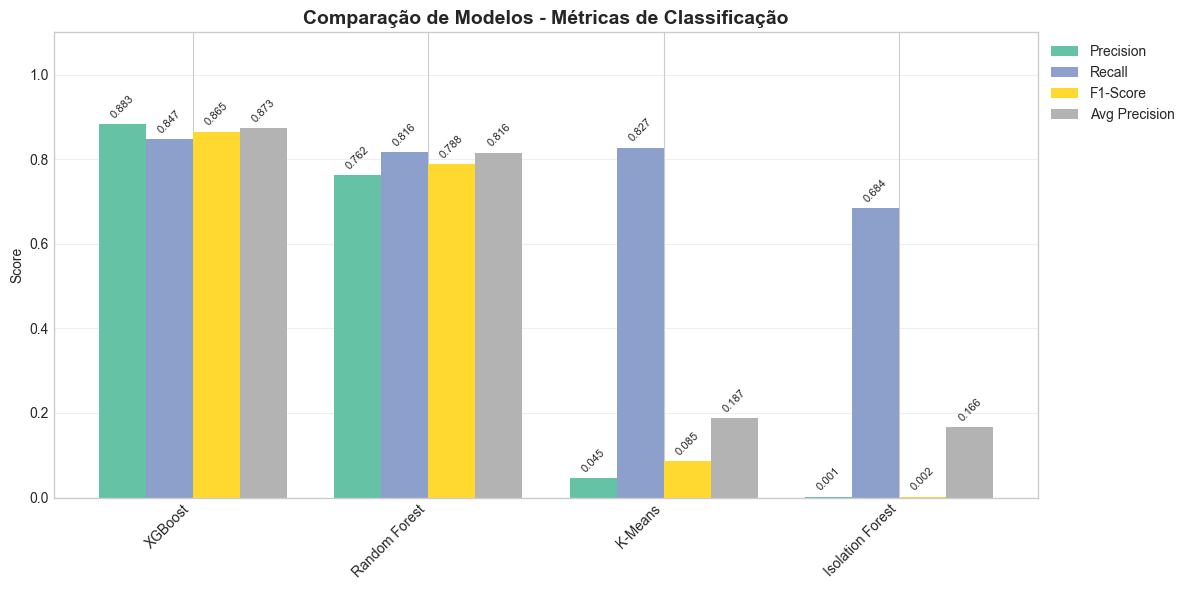

In [77]:
# Visualização: Comparação de métricas
fig, ax = plt.subplots(figsize=(12, 6))

metrics_to_plot = ['Precision', 'Recall', 'F1-Score', 'Avg Precision']
x = np.arange(len(comparison_df))
width = 0.2

colors = plt.cm.Set2(np.linspace(0, 1, len(metrics_to_plot)))

for i, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    offset = width * (i - len(metrics_to_plot) / 2 + 0.5)
    bars = ax.bar(x + offset, comparison_df[metric], width, label=metric, color=color)
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom', fontsize=8, rotation=45)

ax.set_ylabel('Score')
ax.set_title('Comparação de Modelos - Métricas de Classificação', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 8.1 Curvas ROC

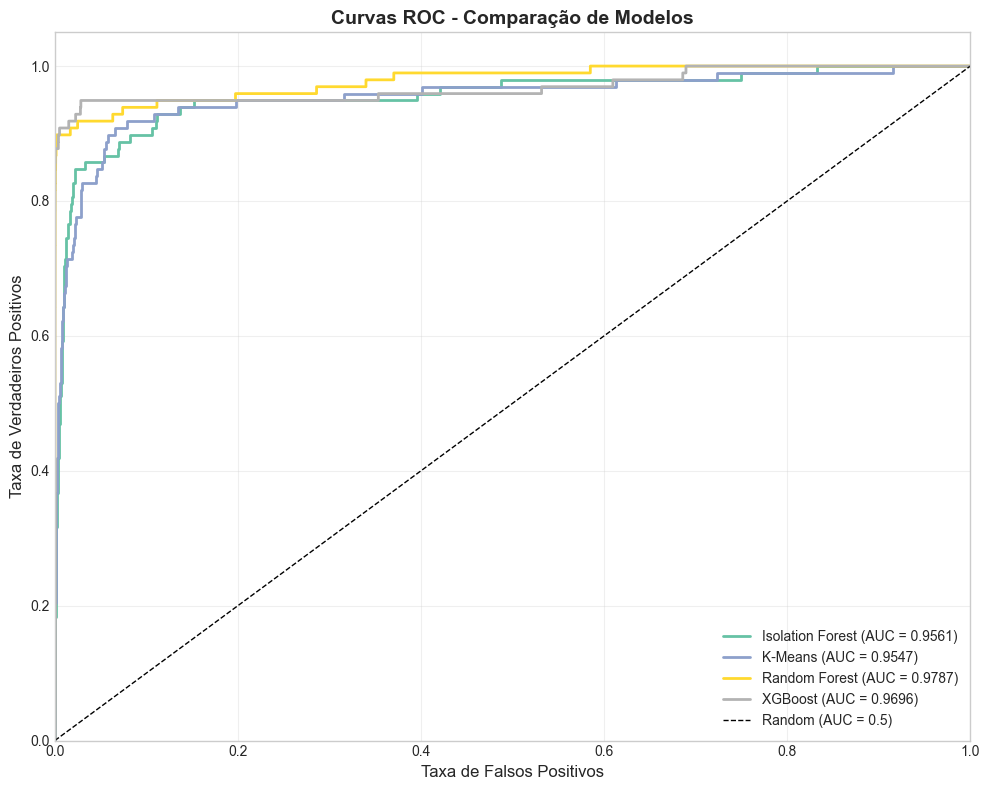

In [78]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.Set2(np.linspace(0, 1, len(all_probabilities)))

for (model_name, y_proba), color in zip(all_probabilities.items(), colors):
    fpr, tpr, _ = roc_curve(y_test.values, y_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.5)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Taxa de Falsos Positivos', fontsize=12)
ax.set_ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
ax.set_title('Curvas ROC - Comparação de Modelos', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 8.2 Curvas Precision-Recall

**Importante**: Para datasets desbalanceados, a curva PR é MAIS INFORMATIVA que ROC!

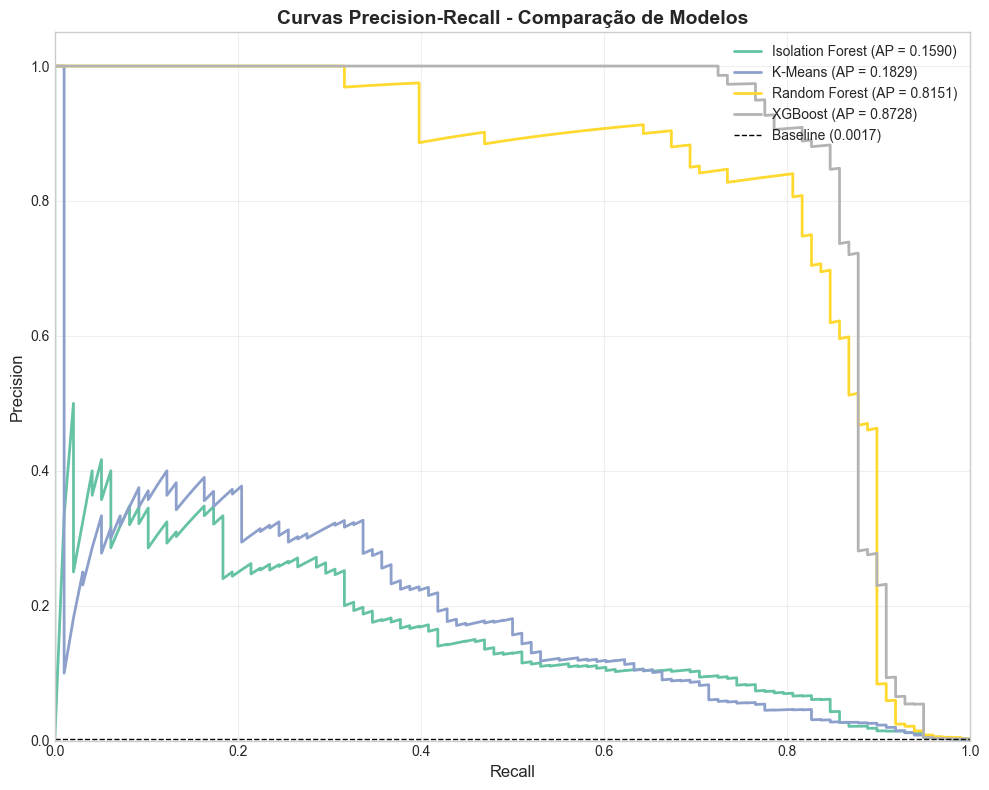

In [79]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.Set2(np.linspace(0, 1, len(all_probabilities)))

for (model_name, y_proba), color in zip(all_probabilities.items(), colors):
    precision, recall, _ = precision_recall_curve(y_test.values, y_proba)
    pr_auc = auc(recall, precision)
    ax.plot(recall, precision, color=color, lw=2, label=f'{model_name} (AP = {pr_auc:.4f})')

# Baseline
baseline = y_test.mean()
ax.axhline(y=baseline, color='k', linestyle='--', lw=1, label=f'Baseline ({baseline:.4f})')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Curvas Precision-Recall - Comparação de Modelos', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 8.3 Matrizes de Confusão

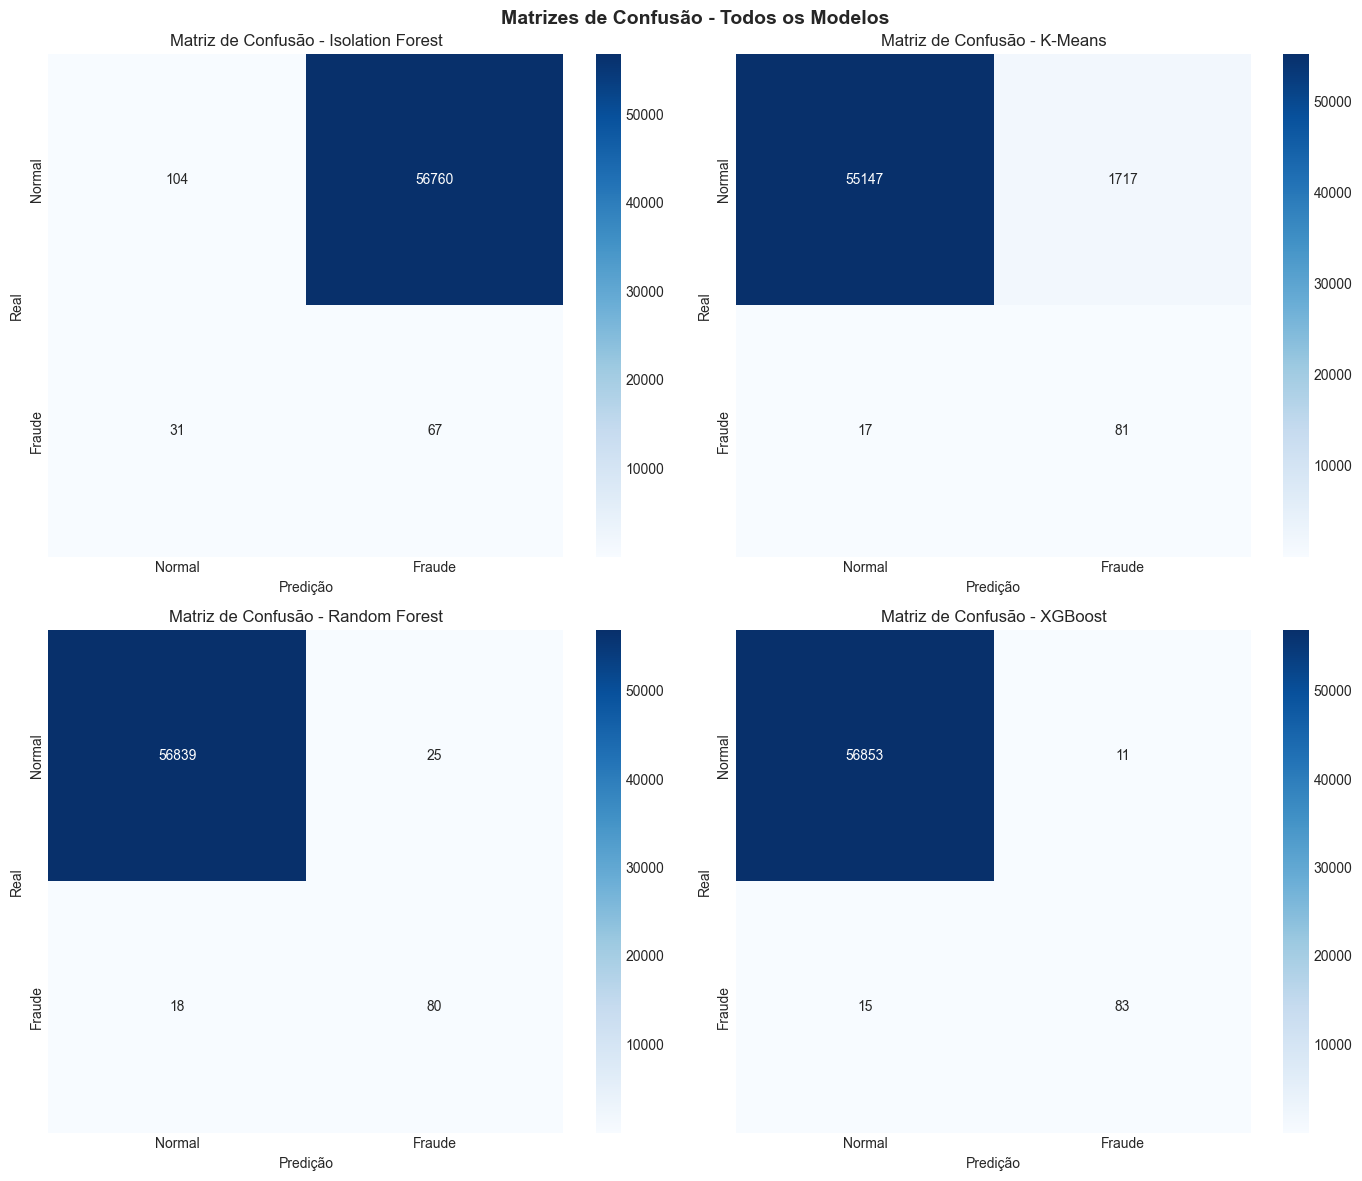

In [80]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (model_name, y_pred) in enumerate(all_predictions.items()):
    cm = confusion_matrix(y_test.values, y_pred)
    
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Normal', 'Fraude'],
        yticklabels=['Normal', 'Fraude'],
        ax=axes[idx]
    )
    
    axes[idx].set_xlabel('Predição')
    axes[idx].set_ylabel('Real')
    axes[idx].set_title(f'Matriz de Confusão - {model_name}')

plt.suptitle('Matrizes de Confusão - Todos os Modelos', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Conclusões e Recomendações

In [ ]:
print_section("CONCLUSÕES E RECOMENDAÇÕES")

In [81]:
# Identificar melhores modelos
best_ap = comparison_df['Avg Precision'].idxmax()
best_recall = comparison_df['Recall'].idxmax()
best_precision = comparison_df['Precision'].idxmax()
best_f1 = comparison_df['F1-Score'].idxmax()

print("RESULTADOS FINAIS")
print("="*60)

print(f"\n📊 MELHOR MODELO GERAL (Average Precision): {best_ap}")
print(f"   - Average Precision: {comparison_df.loc[best_ap, 'Avg Precision']:.4f}")
print(f"   - F1-Score: {comparison_df.loc[best_ap, 'F1-Score']:.4f}")

print(f"\n🎯 MELHOR RECALL (detectar mais fraudes): {best_recall}")
print(f"   - Recall: {comparison_df.loc[best_recall, 'Recall']:.4f}")

print(f"\n✅ MELHOR PRECISION (menos falsos positivos): {best_precision}")
print(f"   - Precision: {comparison_df.loc[best_precision, 'Precision']:.4f}")

print(f"\n⚖️  MELHOR F1-SCORE (equilíbrio): {best_f1}")
print(f"   - F1-Score: {comparison_df.loc[best_f1, 'F1-Score']:.4f}")

RESULTADOS FINAIS

📊 MELHOR MODELO GERAL (Average Precision): XGBoost
   - Average Precision: 0.8730
   - F1-Score: 0.8646

🎯 MELHOR RECALL (detectar mais fraudes): XGBoost
   - Recall: 0.8469

✅ MELHOR PRECISION (menos falsos positivos): XGBoost
   - Precision: 0.8830

⚖️  MELHOR F1-SCORE (equilíbrio): XGBoost
   - F1-Score: 0.8646


In [82]:
print("\n" + "="*60)
print("ANÁLISE COMPARATIVA")
print("="*60)

print("""
📌 MODELOS NÃO SUPERVISIONADOS (Isolation Forest, K-Means):

   VANTAGENS:
   • Não precisam de labels para treinar
   • Detectam anomalias baseadas em distribuição
   • Podem capturar novos padrões de fraude
   
   DESVANTAGENS:
   • Menor precisão que modelos supervisionados
   • Mais falsos positivos
   • Não aprendem padrões específicos de fraude

📌 MODELOS SUPERVISIONADOS (Random Forest, XGBoost):

   VANTAGENS:
   • Aprendem padrões específicos de fraude dos dados
   • Melhor precisão e recall
   • Fornecem probabilidades calibradas
   • Importância de features para interpretabilidade
   
   DESVANTAGENS:
   • Precisam de dados rotulados
   • Podem não detectar novos tipos de fraude
   • Sensíveis a drift nos dados
""")


ANÁLISE COMPARATIVA

📌 MODELOS NÃO SUPERVISIONADOS (Isolation Forest, K-Means):

   VANTAGENS:
   • Não precisam de labels para treinar
   • Detectam anomalias baseadas em distribuição
   • Podem capturar novos padrões de fraude

   DESVANTAGENS:
   • Menor precisão que modelos supervisionados
   • Mais falsos positivos
   • Não aprendem padrões específicos de fraude

📌 MODELOS SUPERVISIONADOS (Random Forest, XGBoost):

   VANTAGENS:
   • Aprendem padrões específicos de fraude dos dados
   • Melhor precisão e recall
   • Fornecem probabilidades calibradas
   • Importância de features para interpretabilidade

   DESVANTAGENS:
   • Precisam de dados rotulados
   • Podem não detectar novos tipos de fraude
   • Sensíveis a drift nos dados



In [83]:
print("\n" + "="*60)
print("RECOMENDAÇÕES PARA PRODUÇÃO")
print("="*60)

print(f"""
1. MODELO PRINCIPAL:
   → Use {best_ap} como modelo principal de detecção
   → Ajuste o threshold conforme tolerância a falsos positivos

2. SISTEMA HÍBRIDO (RECOMENDADO):
   → Combine modelo supervisionado + Isolation Forest
   → Supervisionado detecta padrões conhecidos
   → Isolation Forest captura anomalias inéditas

3. MONITORAMENTO:
   → Monitore métricas em tempo real
   → Retreine periodicamente com novos dados
   → Detecte drift nos padrões de fraude

4. THRESHOLD:
   → Threshold alto (0.7+): Menos falsos positivos, pode perder fraudes
   → Threshold baixo (0.3-): Mais detecções, mais falsos positivos
   → Ajuste conforme custo de cada tipo de erro

5. FEATURES IMPORTANTES:
   → V14, V12, V10, V17 são as mais discriminativas
   → Amount_log e PCA_magnitude também contribuem
   → Monitore se importância muda ao longo do tempo
""")


RECOMENDAÇÕES PARA PRODUÇÃO

1. MODELO PRINCIPAL:
   → Use XGBoost como modelo principal de detecção
   → Ajuste o threshold conforme tolerância a falsos positivos

2. SISTEMA HÍBRIDO (RECOMENDADO):
   → Combine modelo supervisionado + Isolation Forest
   → Supervisionado detecta padrões conhecidos
   → Isolation Forest captura anomalias inéditas

3. MONITORAMENTO:
   → Monitore métricas em tempo real
   → Retreine periodicamente com novos dados
   → Detecte drift nos padrões de fraude

4. THRESHOLD:
   → Threshold alto (0.7+): Menos falsos positivos, pode perder fraudes
   → Threshold baixo (0.3-): Mais detecções, mais falsos positivos
   → Ajuste conforme custo de cada tipo de erro

5. FEATURES IMPORTANTES:
   → V14, V12, V10, V17 são as mais discriminativas
   → Amount_log e PCA_magnitude também contribuem
   → Monitore se importância muda ao longo do tempo



In [84]:
# Tabela final formatada
print("\n" + "="*60)
print("TABELA RESUMO")
print("="*60 + "\n")

comparison_df_styled = comparison_df.copy()
comparison_df_styled


TABELA RESUMO



,Precision,Recall,F1-Score,ROC-AUC,Avg Precision
Modelo,,,,,
XGBoost,0.8830,0.8469,0.8646,0.9696,0.8730
Random Forest,0.7619,0.8163,0.7882,0.9787,0.8157
K-Means,0.0451,0.8265,0.0854,0.9547,0.1872
Isolation Forest,0.0012,0.6837,0.0024,0.9561,0.1658


## 10. Salvar Modelos para Deploy

In [85]:
import joblib
from pathlib import Path

# Criar diretório
MODELS_DIR = Path('models_saved')
MODELS_DIR.mkdir(exist_ok=True)

# Salvar modelos
joblib.dump(xgb_model, MODELS_DIR / 'xgboost_model.pkl')
joblib.dump(rf_model, MODELS_DIR / 'random_forest_model.pkl')
joblib.dump(iso_forest, MODELS_DIR / 'isolation_forest_model.pkl')
joblib.dump(kmeans, MODELS_DIR / 'kmeans_model.pkl')
joblib.dump(scaler, MODELS_DIR / 'scaler.pkl')

print(f"✓ Modelos salvos em: {MODELS_DIR.absolute()}")
print("\nArquivos:")
for f in MODELS_DIR.glob('*.pkl'):
    print(f"  - {f.name}")

✓ Modelos salvos em: d:\Downloads\models_saved

Arquivos:
  - isolation_forest_model.pkl
  - kmeans_model.pkl
  - random_forest_model.pkl
  - scaler.pkl
  - xgboost_model.pkl


## 11. Exemplo de Uso em Produção

In [86]:
def predict_fraud(transaction_data, model_path='models_saved'):
    """
    Função para predição de fraude em produção.
    
    Args:
        transaction_data: DataFrame com dados da transação
        model_path: Caminho para os modelos salvos
        
    Returns:
        Dicionário com predição e probabilidade
    """
    model_path = Path(model_path)
    
    # Carregar modelos
    model = joblib.load(model_path / 'xgboost_model.pkl')
    scaler = joblib.load(model_path / 'scaler.pkl')
    
    # Escalar dados
    X_scaled = scaler.transform(transaction_data)
    
    # Predição
    proba = model.predict_proba(X_scaled)[:, 1]
    pred = (proba >= 0.5).astype(int)
    
    return {
        'is_fraud': bool(pred[0]),
        'fraud_probability': float(proba[0]),
        'risk_level': 'HIGH' if proba[0] > 0.7 else 'MEDIUM' if proba[0] > 0.3 else 'LOW'
    }

# Exemplo de uso
sample = X_test.iloc[[0]]
result = predict_fraud(sample)

print("Exemplo de predição:")
print(f"  É fraude: {result['is_fraud']}")
print(f"  Probabilidade: {result['fraud_probability']:.4f}")
print(f"  Nível de risco: {result['risk_level']}")
print(f"  Classe real: {y_test.iloc[0]}")

Exemplo de predição:
  É fraude: False
  Probabilidade: 0.0000
  Nível de risco: LOW
  Classe real: 0


---

## Resumo do Projeto

Este notebook implementou um sistema completo de detecção de fraude comparando:

1. **EDA**: Análise do desbalanceamento extremo e padrões nas features
2. **Feature Engineering**: Features temporais, de valor e interações
3. **Modelos Não Supervisionados**: Isolation Forest e K-Means
4. **Modelos Supervisionados**: Random Forest e XGBoost
5. **Avaliação Completa**: Métricas, curvas ROC/PR, matrizes de confusão
6. **Deploy**: Modelos salvos prontos para produção

### Próximos Passos
- Implementar API REST para servir predições
- Criar dashboard de monitoramento
- Testar ensemble dos modelos
- Implementar retreinamento automático